In [1]:
import pymssql
import re
from collections import OrderedDict
from pandas import Series,DataFrame
from tqdm import tqdm_notebook
conn = pymssql.connect(server='27.122.253.242',database = "MIDW", user="intern", password="dlsxjs")
import pandas as pd
import copy

import urllib.request #이미지 다운로드
import numpy as np

import pickle

import tensorflow as tf


import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Convolution2D,Activation,MaxPooling2D,Concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model


Using TensorFlow backend.


In [2]:
#피클 파일 불러오기 
with open('shoda4000.pickle','rb') as fr: 
    result3 = pickle.load(fr)

In [3]:
#다른 크기 이미지 제거하고 인덱스 섞어주기
for index in result3.index:
    if result3.loc[index]['pl_imgurl'].shape != (28,28,3): 
        result3.drop(index, inplace = True)
result3 = pd.concat([result3],ignore_index=True) 
result3 = result3.reindex(np.random.permutation(result3.index)) 

In [4]:
#정보비율 확인
result3.LABEL.value_counts() 

0    3833
2    3549
6    3105
1    3068
4    2989
3    2511
7    2453
5    2395
Name: LABEL, dtype: int64

In [5]:
#원핫벡터 정답 label 만들기
from keras.utils.np_utils import to_categorical
labels = to_categorical(result3['LABEL'], num_classes =8) 
print(labels[:10])

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [6]:
vocabulary_size = 10000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(result3['pl_goodsnm'])

sequences= tokenizer.texts_to_sequences(result3['pl_goodsnm'])
data = pad_sequences(sequences, maxlen=10)

from sklearn.model_selection import train_test_split
data_train,data_test,labels_train,labels_test = train_test_split(data,labels, test_size = 0.25, random_state=42)#train pl_goodsnm만 임베딩 시켜보자
data_train_image,data_test_image,labels_train_image,labels_test_image = train_test_split(np.array(result3['pl_imgurl'].tolist()),labels, test_size = 0.25, random_state=42)

In [7]:
#임벨런스드 데이터 오버 샘플링 - 시간 오래걸림,성능개선 x
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state=12)
# data_train_sm, labels_train_sm = sm.fit_sample(data_train,labels_train)

In [8]:
#lstm
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

lstm_model = Sequential()
lstm_model.add(Embedding(10000, 200, input_length=10))
lstm_model.add(LSTM(10, activation = 'relu'))
# model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(9,activation='softmax'))
# lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #multi classification에는 categorical_crossentropy 써야함
# lstm_model.fit(data_train,labels_train, epochs=3,batch_size = 2000, validation_split = 0.2,callbacks=[early_stopping])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#cnn
cnn_model = Sequential()
cnn_model.add(Convolution2D(16, 3, 3, border_mode='same', activation='relu',
                        input_shape=data_train_image.shape[1:]))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
  
cnn_model.add(Convolution2D(64, 3, 3,  activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
 
cnn_model.add(Convolution2D(64, 3, 3))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
  
cnn_model.add(Flatten())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 3..., padding="same")`
  after removing the cwd from sys.path.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if sys.path[0] == '':


In [10]:
out = Concatenate(axis=1)([lstm_model.output,cnn_model.output])
out = Dense(8,activation='softmax')(out)
conc_model = Model([lstm_model.input,cnn_model.input],out)
conc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #multi classification에는 categorical_crossentropy 써야함
hist = conc_model.fit([data_train,data_train_image],labels_train, epochs=30,batch_size = 500,validation_split = 0.2,callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Train on 14341 samples, validate on 3586 samples
Epoch 1/30
14341/14341 [==============================] - ETA: 1:27 - loss: 2.1135 - acc: 0.120 - ETA: 47s - loss: 2.0974 - acc: 0.144 - ETA: 33s - loss: 2.1023 - acc: 0.14 - ETA: 26s - loss: 2.1017 - acc: 0.15 - ETA: 22s - loss: 2.1020 - acc: 0.14 - ETA: 19s - loss: 2.0963 - acc: 0.14 - ETA: 16s - loss: 2.0911 - acc: 0.15 - ETA: 14s - loss: 2.0874 - acc: 0.15 - ETA: 13s - loss: 2.0853 - acc: 0.14 - ETA: 11s - loss: 2.0839 - acc: 0.15 - ETA: 10s - loss: 2.0807 - acc: 0.15 - ETA: 9s - loss: 2.0791 - acc: 0.1540 - ETA: 8s - loss: 2.0773 - acc: 0.156 - ETA: 8s - loss: 2.0755 - acc: 0.157 - ETA: 7s - loss: 2.0749 - acc: 0.156 - ETA: 6s - loss: 2.0737 - acc: 0.156 - ETA: 6s - loss: 2.0725 - acc: 0.156 - ETA: 5s - loss: 2.0706 - acc: 0.158 - ETA: 4s - loss: 2.0691 - acc: 0.159 - ETA: 4s - loss: 2.0674 - acc: 0.160 - ETA: 3s - loss: 2.0654 - acc: 0.162 - ETA: 3s - loss: 2.0641 - acc: 0.163 - ETA: 

14341/14341 [==============================] - ETA: 17s - loss: 0.2211 - acc: 0.95 - ETA: 15s - loss: 0.1945 - acc: 0.95 - ETA: 15s - loss: 0.2108 - acc: 0.94 - ETA: 14s - loss: 0.2206 - acc: 0.94 - ETA: 14s - loss: 0.2130 - acc: 0.94 - ETA: 13s - loss: 0.2205 - acc: 0.93 - ETA: 12s - loss: 0.2191 - acc: 0.93 - ETA: 12s - loss: 0.2156 - acc: 0.94 - ETA: 11s - loss: 0.2201 - acc: 0.93 - ETA: 11s - loss: 0.2192 - acc: 0.93 - ETA: 10s - loss: 0.2168 - acc: 0.94 - ETA: 10s - loss: 0.2160 - acc: 0.94 - ETA: 9s - loss: 0.2163 - acc: 0.9405 - ETA: 8s - loss: 0.2176 - acc: 0.940 - ETA: 8s - loss: 0.2141 - acc: 0.941 - ETA: 7s - loss: 0.2167 - acc: 0.939 - ETA: 6s - loss: 0.2200 - acc: 0.939 - ETA: 6s - loss: 0.2253 - acc: 0.938 - ETA: 5s - loss: 0.2260 - acc: 0.938 - ETA: 5s - loss: 0.2246 - acc: 0.939 - ETA: 4s - loss: 0.2228 - acc: 0.939 - ETA: 4s - loss: 0.2252 - acc: 0.940 - ETA: 3s - loss: 0.2256 - acc: 0.940 - ETA: 2s - loss: 0.2251 - acc: 0.940 - ETA: 2s - loss: 0.2247 - acc: 0.940 - ET

In [11]:
accr = conc_model.evaluate([data_test,data_test_image],labels_test)

5976/5976 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 775us/step


In [12]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.557
  Accuracy: 0.854


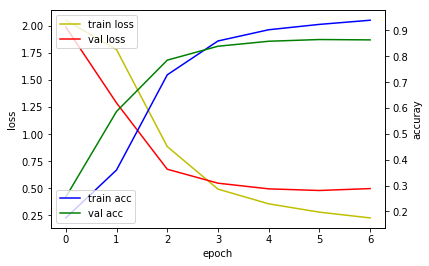

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()